In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.holtwinters import ExponentialSmoothing


### Part 1- preprocessing:

In [3]:
file_path = "International_Report_Departures.csv"
df = pd.read_csv(file_path)
display(df) #visualisation without aggregation

,data_dte,Year,Month,usg_apt_id,usg_apt,usg_wac,fg_apt_id,fg_apt,fg_wac,airlineid,carrier,carriergroup,type,Scheduled,Charter,Total
0,05/01/2006,2006,5,12016,GUM,5,13162,MAJ,844,20177,PFQ,1,Departures,0,10,10
1,05/01/2003,2003,5,10299,ANC,1,13856,OKO,736,20007,5Y,1,Departures,0,15,15
2,03/01/2007,2007,3,10721,BOS,13,12651,KEF,439,20402,GL,1,Departures,0,1,1
3,12/01/2004,2004,12,11259,DAL,74,16271,YYZ,936,20201,AMQ,1,Departures,0,1,1
4,05/01/2009,2009,5,13303,MIA,33,11075,CMW,219,21323,5L,0,Departures,0,20,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930803,07/01/2000,2000,7,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1422,0,1422
930804,04/01/2019,2019,4,13303,MIA,33,14286,PTY,162,19770,CM,0,Departures,1439,0,1439
930805,08/01/2000,2000,8,13303,MIA,33,13605,NAS,204,20398,MQ,1,Departures,1441,0,1441
930806,09/01/2004,2004,9,12266,IAH,74,15632,VSA,148,19534,AM,0,Departures,1461,0,1461


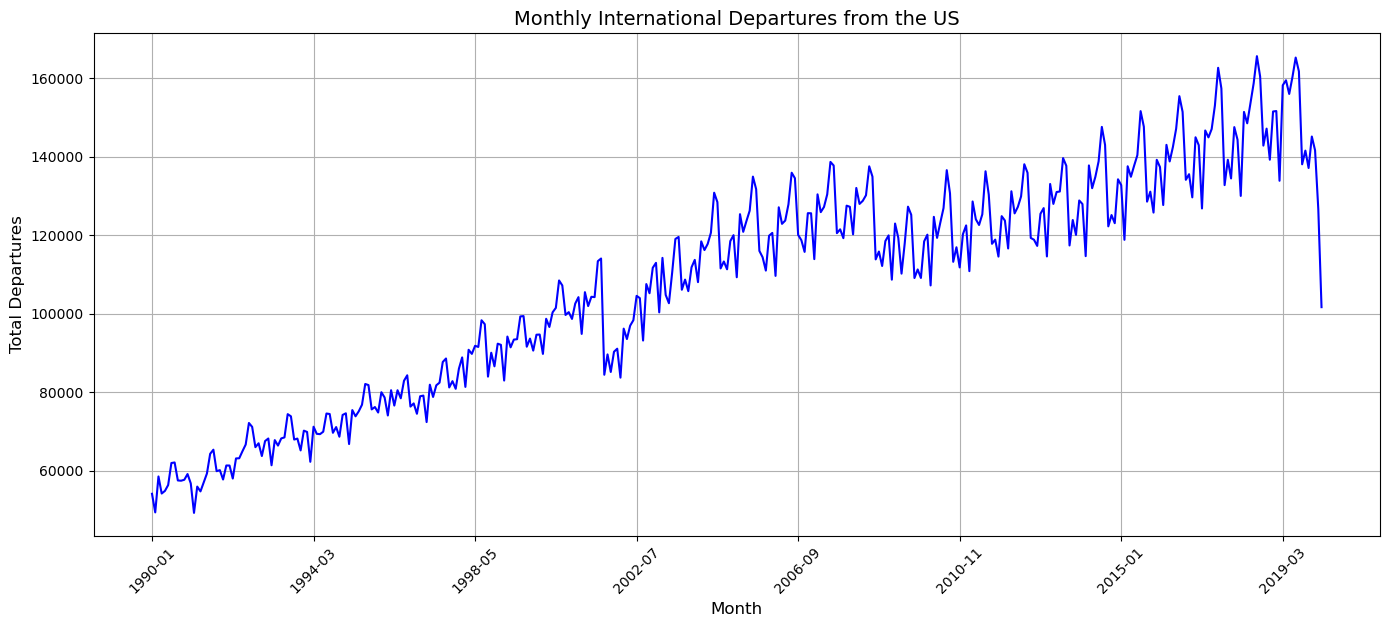

In [4]:
# Convert date column to datetime
df['data_dte'] = pd.to_datetime(df['data_dte'])

# Create a year-month column
df['year_month'] = df['data_dte'].dt.to_period('M')

# Aggregate by month: sum total departures
monthly_departures = df.groupby('year_month')['Total'].sum()

# Convert the index to string for readable axis labels
monthly_departures.index = monthly_departures.index.astype(str)

# Plotting the graph
plt.figure(figsize=(14, 6))
monthly_departures.plot(color='blue')
plt.title("Monthly International Departures from the US", fontsize=14)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Total Departures", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [5]:
print(monthly_departures.isna().sum())        # count NaNs
print(monthly_departures.index.is_unique)     # does the dates are unique?

0
True


Text(0, 0.5, 'Total Departures')

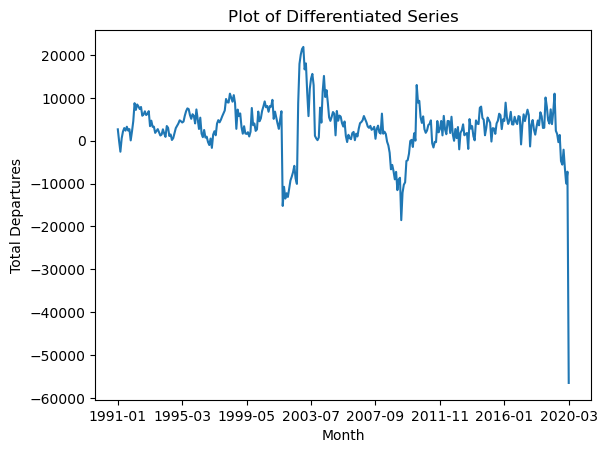

In [6]:
#Substract seasonality by using differncing
data_without_seasonality = monthly_departures.diff(periods=12)
data_without_seasonality = data_without_seasonality.dropna()
#Plot the transformed data
data_without_seasonality.plot()
plt.title("Plot of Differentiated Series")
plt.xlabel("Month")
plt.ylabel("Total Departures")

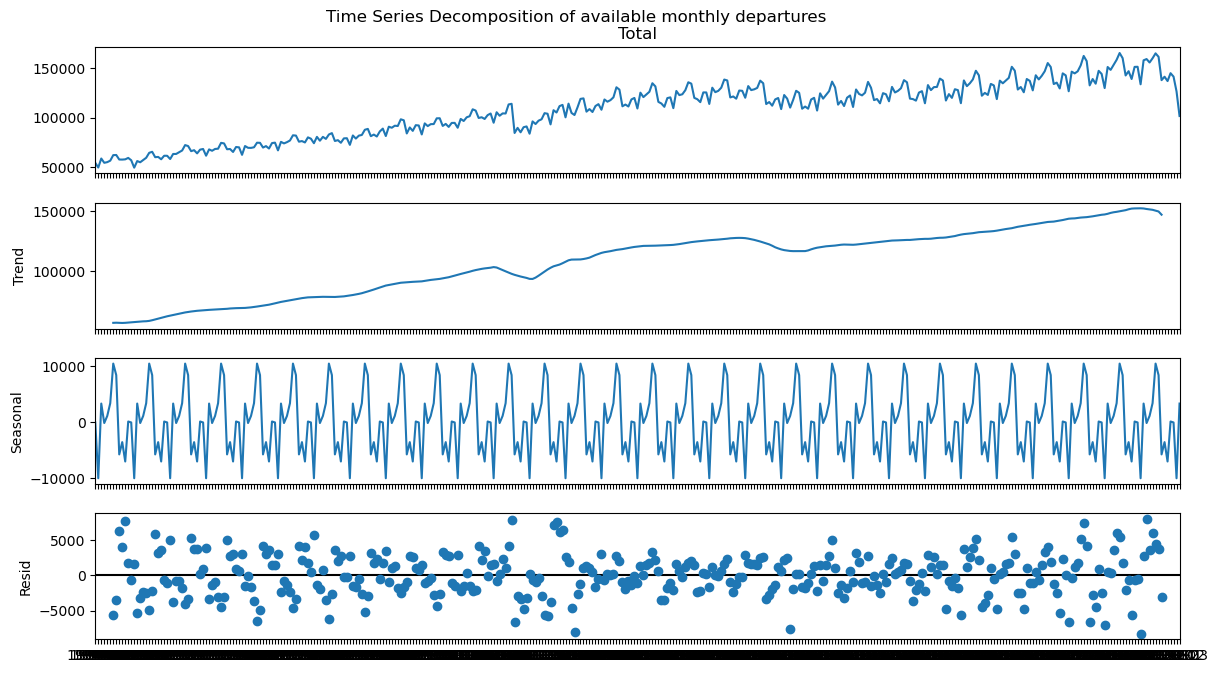

In [7]:
# Decompose the time series into trend, seasonal, and residual components
decomposition = seasonal_decompose(monthly_departures, model='additive', period=12)

# Plot the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 7)
plt.suptitle('Time Series Decomposition of available monthly departures')
plt.show()

### Part 2

### Sarima models:

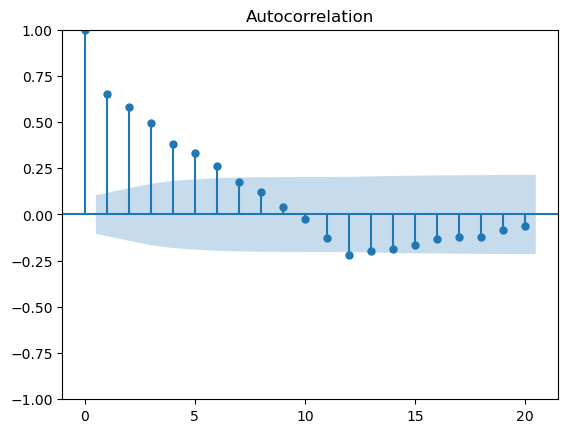

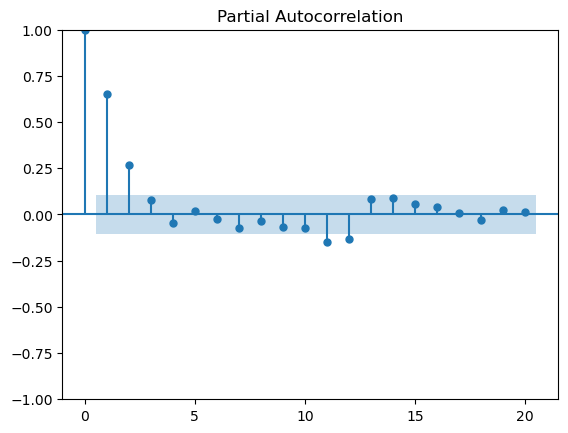

In [10]:
#Plotting the autocorrelation for the new series
tsaplots.plot_acf(data_without_seasonality, lags=20)
tsaplots.plot_pacf(data_without_seasonality, lags=20)
plt.show()

The model looks like AR(1) or equivalent to SARIMA(1,0,0)(0,1,0)_12. That because the Autocorrelation gradually decreases over time in a geometric decay pattern, which is typical for an AR(1) process. Also Partial Autocorrelation shows a significant spike at lag 2 and then cuts off sharply, so AR(2) is more likely. Another option is SARIMA(1,0,0)(1,1,0)_12 because the PACF acts like the AR's PACF. Also we can see a peak at t=11 and 12, that implies that maybe there is also AR seasonality.
In conclusion we will check: SARIMA(p,0,0)(0,1,0)_12 and SARIMA(p,0,0)(1,1,0)_12 for p=1,2


In [12]:
#SARIMA(1,0,0)(0,1,0)_{s=12}
model_AR1 = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(0,1,0,12))
model_AR1 = model_AR1.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [13]:
#SARIMA(1,0,0)(1,1,0)_{s=12}
model_AR1s = SARIMAX(monthly_departures, order=(1,0,0), seasonal_order=(1,1,0,12))
model_AR1s = model_AR1s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [14]:
#SARIMA(2,0,0)(0,1,0)_{s=12}
model_AR2 = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(0,1,0,12))
model_AR2 = model_AR2.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [15]:
#SARIMA(2,0,0)(1,1,0)_{s=12}
model_AR2s = SARIMAX(monthly_departures, order=(2,0,0), seasonal_order=(1,1,0,12))
model_AR2s = model_AR2s.fit(disp=False)

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [16]:
#Check the models BICs
print(f'Model AR1 BIC is : {model_AR1.bic}')
print(f'Model AR1s BIC is : {model_AR1s.bic}')
print(f'Model AR2 BIC is : {model_AR2.bic}')
print(f'Model AR2s BIC is : {model_AR2s.bic}')

Model AR1 BIC is : 6941.8338616524625
Model AR1s BIC is : 6894.773305865163
Model AR2 BIC is : 6947.446536773032
Model AR2s BIC is : 6893.540203480104


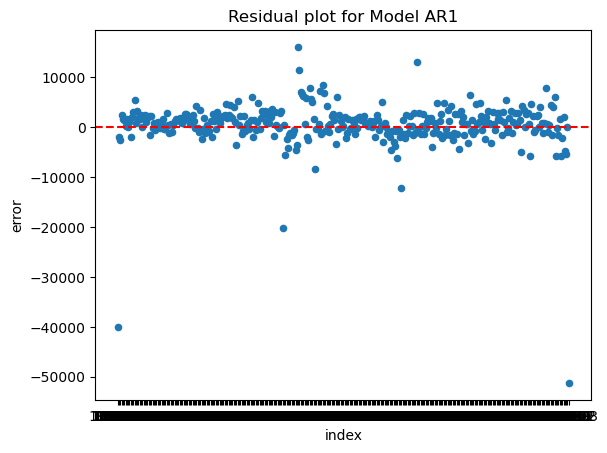

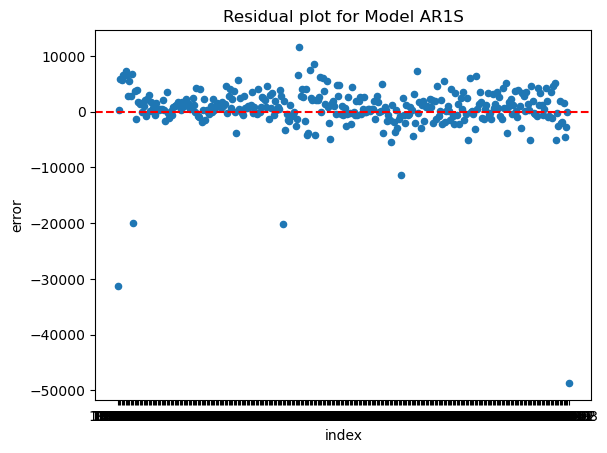

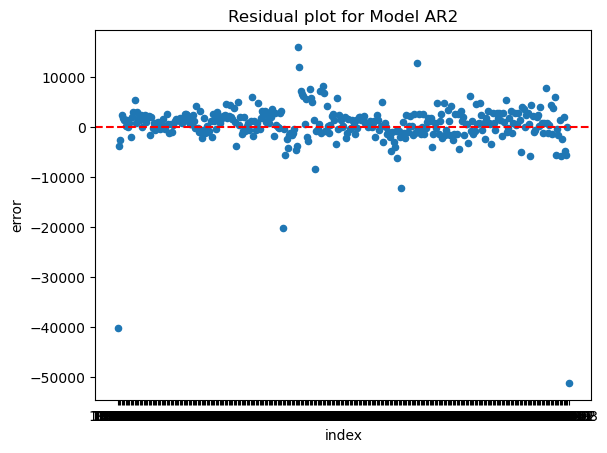

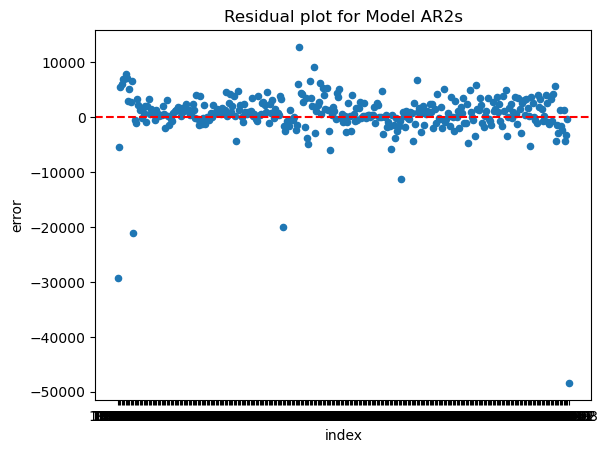

In [17]:
#Plot residual plots for every model


#Model AR1
res_plot = pd.DataFrame(model_AR1.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1")
plt.show()

#Model AR1S
res_plot = pd.DataFrame(model_AR1s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR1S")
plt.show()

#Model AR2
res_plot = pd.DataFrame(model_AR2.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2")
plt.show()

#Model AR2s
res_plot = pd.DataFrame(model_AR2s.resid.iloc[12:], columns = ['error'])
res_plot['index'] = res_plot.index
res_plot.plot.scatter(x='index', y="error")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residual plot for Model AR2s")
plt.show()

As we can see, the fourth model SARIMA(2,0,0)(1,1,0)_{s=12} , is a better fit and it has a lower BIC.All the models have pretty much the same residuals , so we will choose SARIMA(2,0,0)(1,1,0)_{s=12} as the best model.

In [19]:
print(model_AR2s.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              Total   No. Observations:                  363
Model:             SARIMAX(2, 0, 0)x(1, 1, 0, 12)   Log Likelihood               -3435.049
Date:                            Sat, 29 Mar 2025   AIC                           6878.097
Time:                                    17:41:31   BIC                           6893.540
Sample:                                01-01-1990   HQIC                          6884.243
                                     - 03-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6786      0.060     11.316      0.000       0.561       0.796
ar.L2          0.1610      0.062   

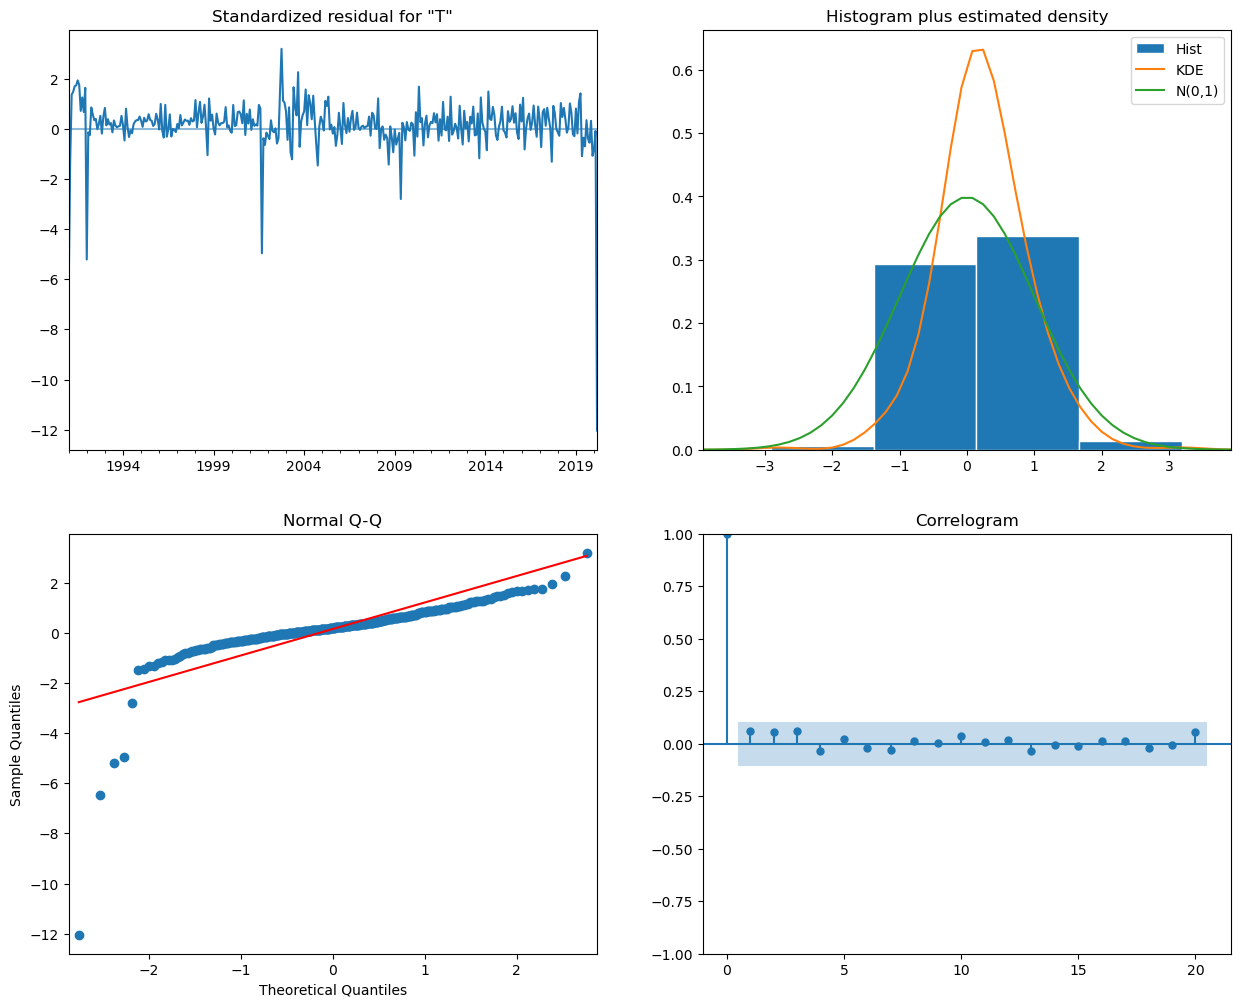

In [20]:
#Plot diagnostics
model_AR2s.plot_diagnostics(lags=20,figsize=(15, 12))
plt.show()

It's a good fit because in the QQ plot the dots  align with the line. Also, in the histogram the KDE fit very well the normal distrebution. 

In [22]:
# Forecast 60 steps ahead
forecast_steps = 60
forecast_result = model_AR2s.get_forecast(steps=forecast_steps)

# Get predicted mean and confidence intervals
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

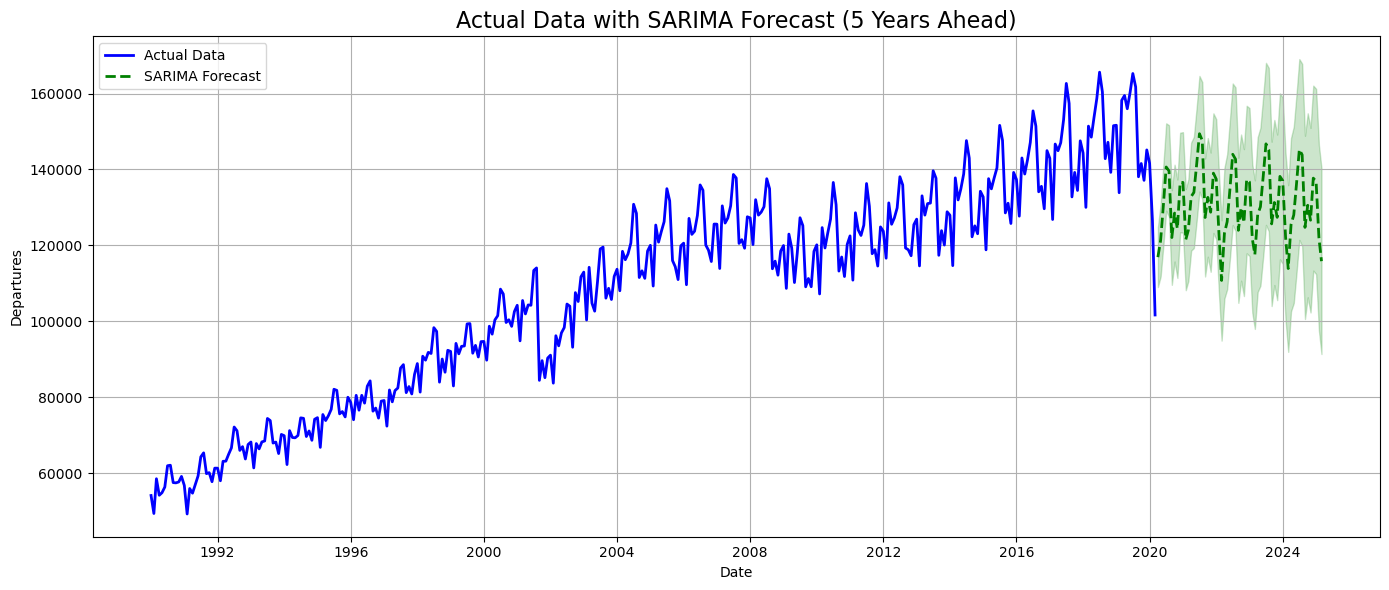

In [23]:
plt.figure(figsize=(14, 6))
monthly_departures.index = pd.to_datetime(monthly_departures.index)

# Plot actual data
plt.plot(monthly_departures, label='Actual Data', color='blue', linewidth=2)

# Plot forecast
forecast_index = pd.date_range(start=monthly_departures.index[-1] + pd.offsets.MonthBegin(1), 
                               periods=forecast_steps, freq='MS')

plt.plot(forecast_index, forecast_mean, label='SARIMA Forecast', color='green', linestyle='--', linewidth=2)

# Confidence interval
plt.fill_between(forecast_index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='green', alpha=0.2)

# Labels
plt.title('Actual Data with SARIMA Forecast (5 Years Ahead)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Departures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Propthet model:

In [25]:
df_prophet = monthly_departures.reset_index()
df_prophet.columns = ['ds', 'y']

df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])

print(df_prophet.head())

          ds      y
0 1990-01-01  54129
1 1990-02-01  49391
2 1990-03-01  58542
3 1990-04-01  54195
4 1990-05-01  54863


In [26]:
model_p = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=True)
model_p.fit(df_prophet)

17:41:32 - cmdstanpy - INFO - Chain [1] start processing
17:41:32 - cmdstanpy - INFO - Chain [1] done processing


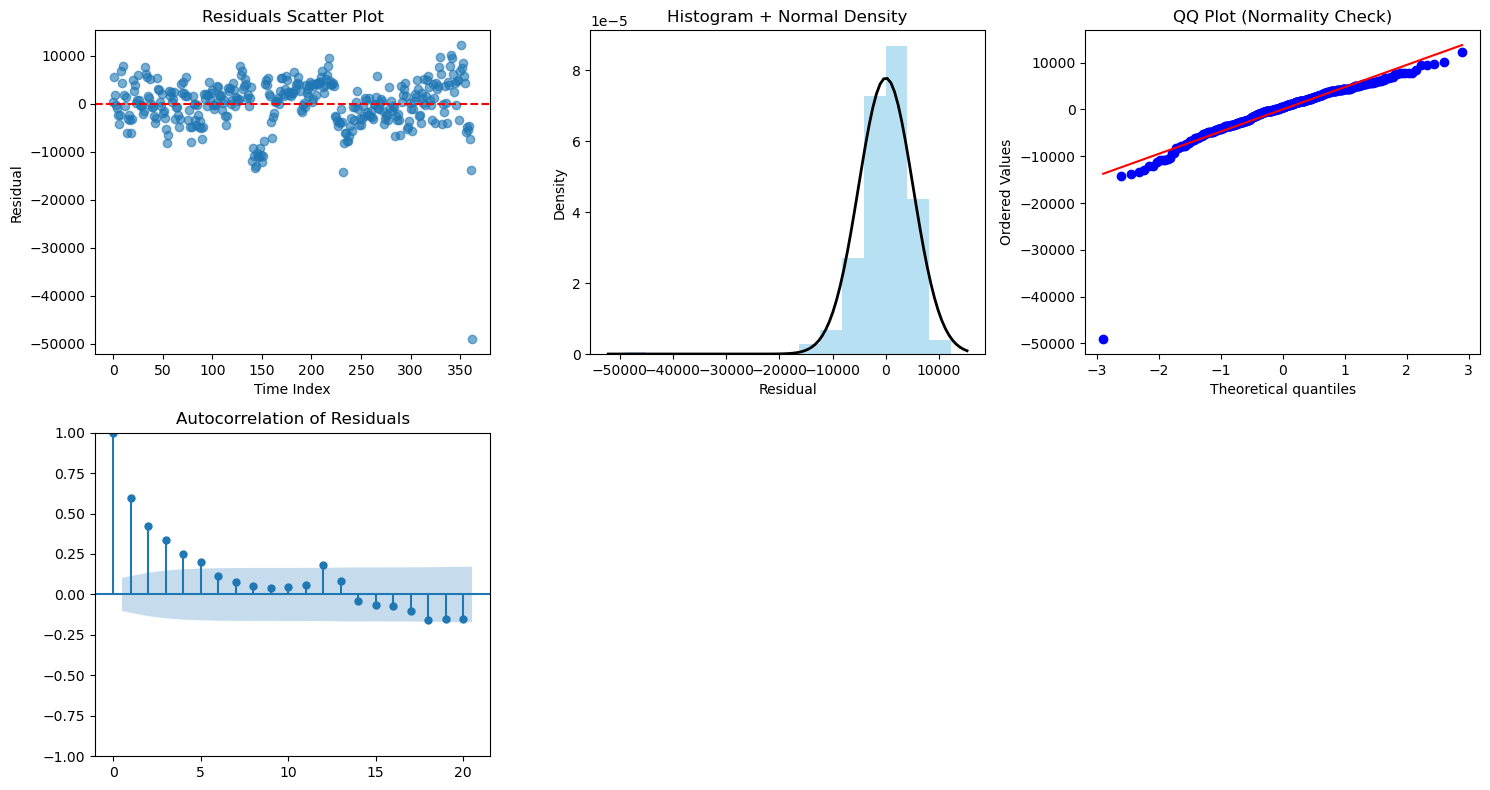

In [27]:
#Create residuals between actual and predicted values
actual = monthly_departures.values
future_df = model_p.make_future_dataframe(periods=365)
forecast_df = model_p.predict(future_df)
predicted = forecast_df['yhat'].iloc[:len(actual)].values
residuals = actual - predicted

#Plot diagnostics
plt.figure(figsize=(15, 8))

# Plot 1: Residuals scatter plot
plt.subplot(231)
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Scatter Plot')
plt.xlabel('Time Index')
plt.ylabel('Residual')

# Plot 2: Histogram with normal distribution overlay
plt.subplot(232)
plt.hist(residuals, bins=15, density=True, alpha=0.6, color='skyblue')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = stats.norm.pdf(x, np.mean(residuals), np.std(residuals))
plt.plot(x, pdf, 'k', linewidth=2)
plt.title('Histogram + Normal Density')
plt.xlabel('Residual')
plt.ylabel('Density')

# Plot 3: QQ Plot to check normality
plt.subplot(233)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot (Normality Check)')

# Plot 4: Autocorrelation of residuals
plt.subplot(234)
plot_acf(residuals, ax=plt.gca(), lags=20)
plt.title('Autocorrelation of Residuals')

plt.tight_layout()
plt.show()

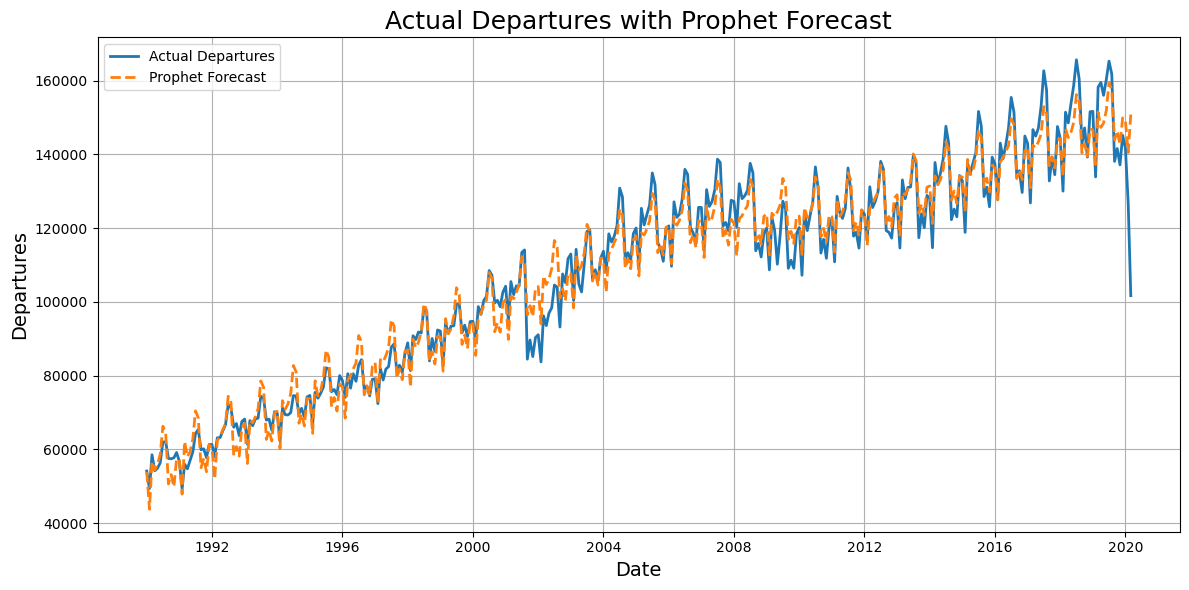

In [28]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)

forecast_df['ds'] = pd.to_datetime(forecast_df['ds'])
# Trim forecast to actual data range
forecast_trimmed = forecast_df[forecast_df['ds'] <= '2020-03-01']

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(monthly_departures.index, monthly_departures.values, label='Actual Departures', linewidth=2)

# Plot forecast
plt.plot(forecast_trimmed['ds'], forecast_trimmed['yhat'], label='Prophet Forecast', linewidth=2, linestyle='--')

plt.title("Actual Departures with Prophet Forecast", fontsize=18)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Departures", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### It seems that this model is a good fit to our data???

### Frocast with prophet:

In [31]:
# Get the last date in your actual data
last_date = monthly_departures.index.max()

# Forecast 5 years ahead (60 months)
future = model_p.make_future_dataframe(periods=60, freq='ME')
forecast = model_p.predict(future)

# Take only the future part of the forecast
forecast_future = forecast[forecast['ds'] > last_date]

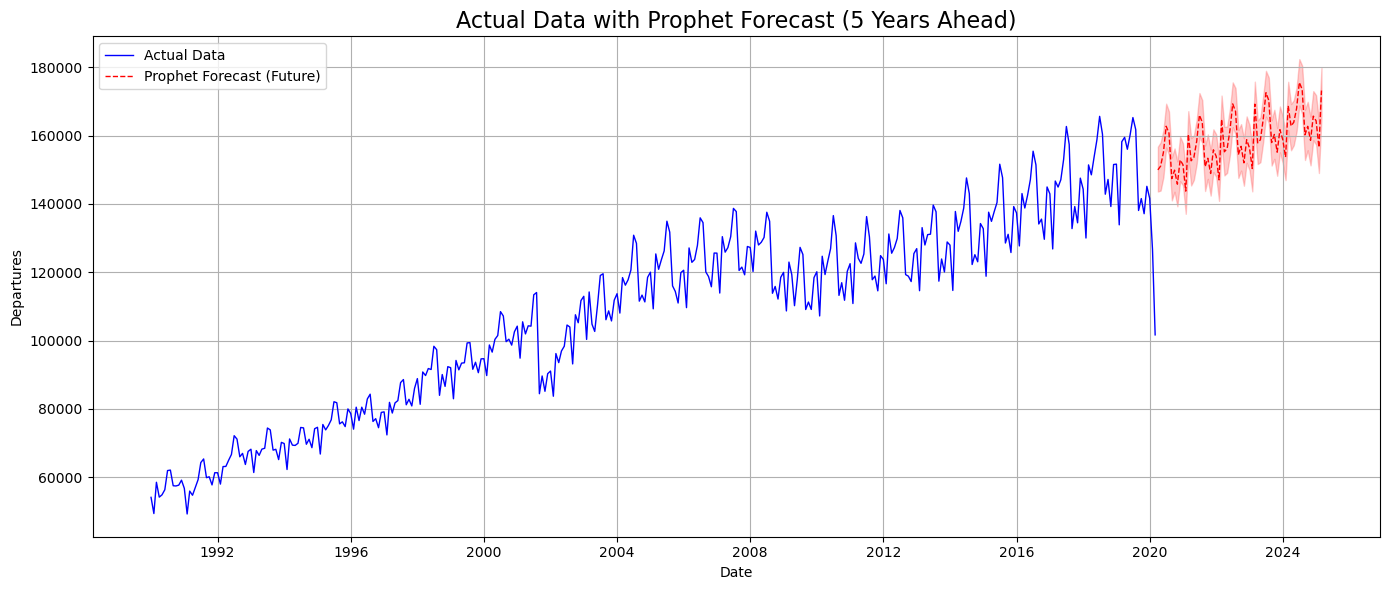

In [32]:
# Actual data
plt.figure(figsize=(14, 6))  

plt.plot(monthly_departures.index, monthly_departures.values, 
         label='Actual Data', color='blue', linewidth=1)

# Forecast line (only future)
plt.plot(forecast_future['ds'], forecast_future['yhat'], 
         label='Prophet Forecast (Future)', color='red', linewidth=1, linestyle='--')

# Confidence interval
plt.fill_between(forecast_future['ds'], 
                 forecast_future['yhat_lower'], 
                 forecast_future['yhat_upper'], 
                 color='red', alpha=0.2)

# Labels & styling
plt.title("Actual Data with Prophet Forecast (5 Years Ahead)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Departures")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Exponential Smoothing with Holt winters:

In [34]:
monthly_departures.index = pd.to_datetime(monthly_departures.index)
monthly_departures = monthly_departures.asfreq('MS')  # Monthly Start

# Fit Exponential Smoothing model with trend and seasonality
model = ExponentialSmoothing(
    monthly_departures,
    trend='add',         
    seasonal='add',
    seasonal_periods=12 )

fit = model.fit()

forecast_steps = 60
forecast_index = pd.date_range(start=monthly_departures.index[-1] + pd.offsets.MonthBegin(1),
                               periods=forecast_steps, freq='MS')

forecast = fit.forecast(forecast_steps)
forecast.index = forecast_index

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


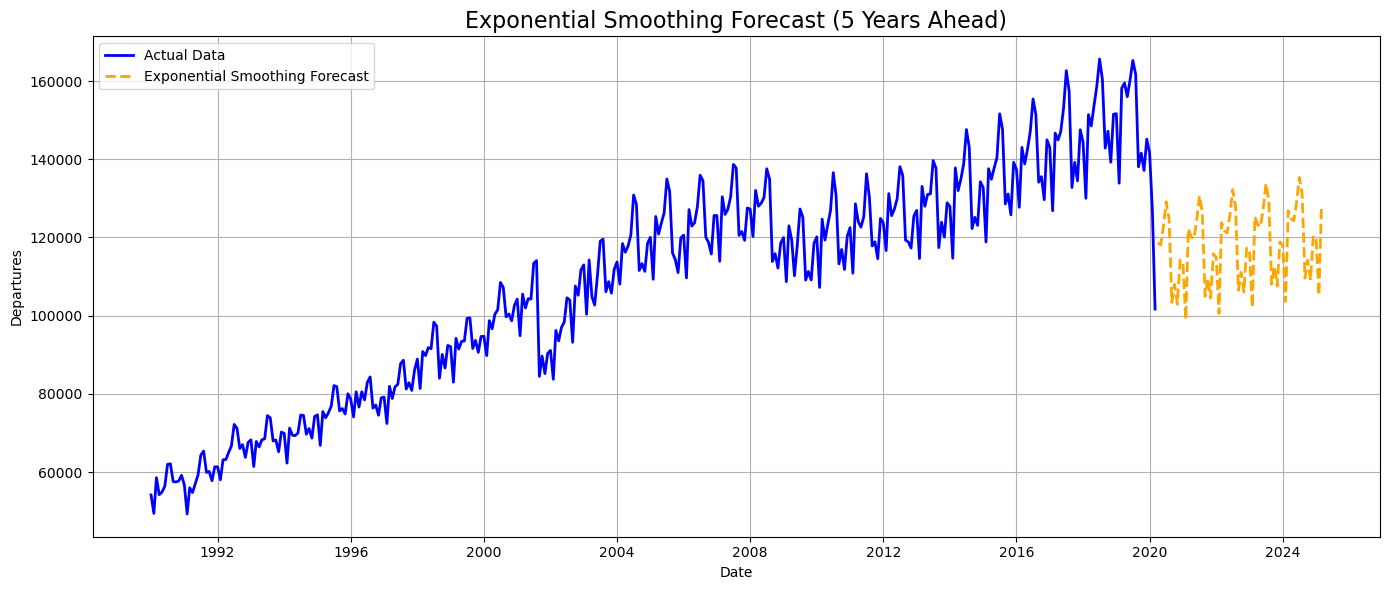

In [35]:
plt.figure(figsize=(14, 6))

# Original data
plt.plot(monthly_departures, label='Actual Data', linewidth=2, color='blue')

# Forecast
plt.plot(forecast, label='Exponential Smoothing Forecast', linewidth=2, color='orange', linestyle='--')

plt.title('Exponential Smoothing Forecast (5 Years Ahead)', fontsize=16)
plt.xlabel('Date')
plt.ylabel('Departures')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Comparison between the 3 models and an explenation to the difference between them taking into account Covid-19:

When comparing the three forecasting models — Prophet, SARIMA, and Exponential Smoothing (Holt-Winters) — each shows a different approach to handling the disruption caused by COVID-19. Prophet projects a strong upward trend with clear seasonality, essentially continuing the pre-pandemic growth as if the drop during COVID-19 was temporary noise. SARIMA, on the other hand, reacts strongly to the COVID-induced drop, producing a volatile forecast with wide confidence intervals, reflecting high uncertainty about future behavior. Exponential Smoothing is the only model that smoothly connects to the latest actual values, but it forecasts a flattened trend, suggesting stabilization rather than a return to rapid growth. Overall, Prophet offers the most optimistic projection, SARIMA the most cautious, while Exponential Smoothing provides a conservative yet visually consistent forecast aligned with recent data.



### Forcast with fourier

In [39]:
monthly_departures = monthly_departures.to_frame(name='departures')

monthly_departures.index = pd.to_datetime(monthly_departures.index)
monthly_departures


,departures
year_month,
1990-01-01,54129
1990-02-01,49391
1990-03-01,58542
1990-04-01,54195
1990-05-01,54863
...,...
2019-11-01,137130
2019-12-01,145140
2020-01-01,141636


In [54]:
rng = pd.date_range(start = '1990-01-01', end = '2020-03-01', freq='MS')
monthly_departures.set_index(rng, inplace=True)#change index to dates.
monthly_departures.head()


,departures,value
1990-01-01,54129,54129.000000
1990-02-01,49391,49259.654696
1990-03-01,58542,58279.309392
1990-04-01,54195,53800.964088
1990-05-01,54863,54337.618785


In [46]:
slope = (
    monthly_departures['departures'].iloc[-1] - 
    monthly_departures['departures'].iloc[0]
) / (len(monthly_departures) - 1)
slope

131.34530386740332

In [50]:
trend_values = np.zeros(len(monthly_departures))
for i in range(len(monthly_departures)):
    trend_values[i] = slope * i

In [52]:
monthly_departures['value'] = monthly_departures['departures'] - trend_values


<Axes: >

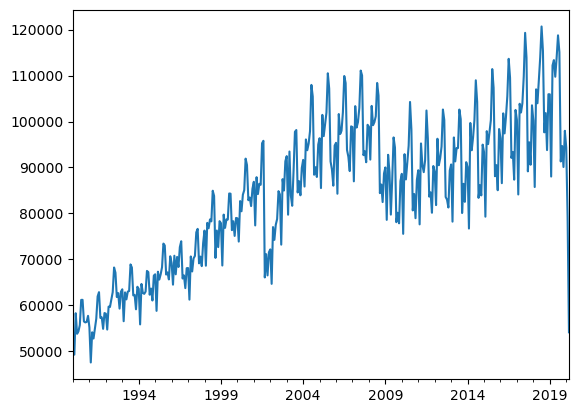

In [58]:
monthly_departures['value'].plot()

as a first step, we attempted to remove a global linear trend from the time series in order to isolate its seasonal component. However, as seen in the detrended series, this approach fails to fully capture the underlying structure of the data. The resulting series still exhibits visible shifts in trend and variability, suggesting that a single linear trend is insufficient. These structural changes, likely due to real-world events or regime shifts, indicate the presence of multiple trend segments over time. To better handle these breaks and to more accurately model the recurring seasonal behavior, we turn to a regression framework that combines Fourier terms with piecewise linear trends. This allows us to flexibly account for both seasonal dynamics and non-uniform trend changes in the data.